In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential, load_model, Model
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from skimage.io import imread,imshow
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from utils import load_data, load_test_data
# from utils import num_classes, epochs, batch_size

In [2]:
data_dir_path = '.'
target_label_file_name = 'mapping.txt'

target_label_file_path = '/'.join((data_dir_path, target_label_file_name))

with open(target_label_file_path) as f:
    all_lines = [line.split(', ') for line in f.read().splitlines()]

target_labels = dict()
for line in all_lines:
    target_class, target_label = line
    target_labels[target_class] = target_label

In [3]:
import os
import cv2
import pandas as pd
from glob import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from time import time
# 指定存放 train 資料集的資料夾
train_dir = '/'.join((data_dir_path, 'img'))
img_path_list = []
img_class_list = []
for key in target_labels.keys():
    for file_path in glob('{}/{}/*.png'.format(train_dir, key)):
        img_class_list.append(target_labels[key])
        img_path_list.append(file_path)

data_list = pd.DataFrame({'class': img_class_list, 'path': img_path_list})

In [4]:
data_list.shape

(3123, 2)

In [5]:
# 將資料清單隨機打亂
# rand_seed = int(time())
# data_list = shuffle(data_list, random_state=612)
# data_list.head(10)

In [6]:
X = pd.DataFrame(data_list['path'], columns=['path'])
y = pd.DataFrame(data_list['class'], columns=['class'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=0,shuffle=True)

In [7]:
imagearray = []
imagearray1 = []
# c=2
# Change the image path with yours.
for path in np.array(X_train['path']):
    img = imread(path)
    img = cv2.resize(img, (299,299))
#     me  = img.mean()
#     std = img.std()
#     nor = (img - me) / std
    imagearray.append(img)
train_x=np.array(imagearray)
for path in np.array(X_valid['path']):
    img1 = imread(path)
    img1 = cv2.resize(img1, (299, 299))
#     me1  = img1.mean()
#     std1 = img1.std()
#     nor1 = (img1 - me1) / std1
    imagearray1.append(img1)
valid_x=np.array(imagearray1)

In [2]:
nb_class=2
model_name = 'Xception-Fine-Tunev1'

img_rows, img_cols, img_channel = 299, 299, 3
base_model = Xception(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_class, activation='softmax', name='classifier')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [10]:
y_one_hot=pd.get_dummies(y_train)
y_train=y_one_hot.values

In [11]:
y_one_hot1=pd.get_dummies(y_valid)
y_valid=y_one_hot1.values

In [14]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['acc'])

batch_size = 10
model_history = model.fit_generator(datagen.flow(train_x, y_train, batch_size = batch_size),
                                    epochs = 500,
                                    validation_data = (valid_x, y_valid),
                                    callbacks = [ checkpoint,earlystop])

Epoch 1/500
249/250 [============================>.] - ETA: 0s - loss: 0.5280 - acc: 0.7356
Epoch 00001: val_loss improved from inf to 0.37311, saving model to ./saved_models/Xception-Fine-Tunev1.h5
250/250 [==============================] - 67s 270ms/step - loss: 0.5274 - acc: 0.7359 - val_loss: 0.3731 - val_acc: 0.8512
Epoch 2/500
249/250 [============================>.] - ETA: 0s - loss: 0.3954 - acc: 0.8238
Epoch 00002: val_loss improved from 0.37311 to 0.29048, saving model to ./saved_models/Xception-Fine-Tunev1.h5
250/250 [==============================] - 48s 194ms/step - loss: 0.3962 - acc: 0.8233 - val_loss: 0.2905 - val_acc: 0.8864
Epoch 3/500
249/250 [============================>.] - ETA: 0s - loss: 0.3297 - acc: 0.8646
Epoch 00003: val_loss improved from 0.29048 to 0.24045, saving model to ./saved_models/Xception-Fine-Tunev1.h5
250/250 [==============================] - 49s 194ms/step - loss: 0.3291 - acc: 0.8651 - val_loss: 0.2404 - val_acc: 0.9184
Epoch 4/500
249/250 [==

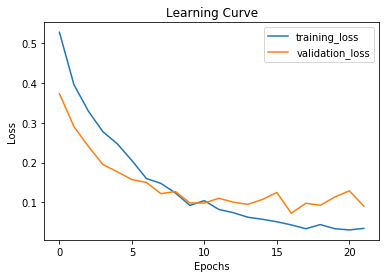

In [15]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

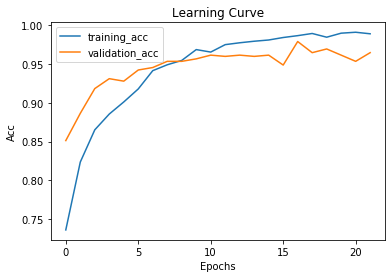

In [16]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [17]:
scores = model.evaluate(valid_x, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

625/625 [==============================] - 3s 4ms/step
Validation loss: 0.09072025223076344
Validation accuracy: 0.9648


In [3]:
test_filename = '/home/yared/文件/ISBI2021/Evaluation_Set/'
test_file_csv = pd.read_csv('/home/yared/文件/ISBI2021/class_28/result/v1/WWW_results(good).csv')
test_X = []
m1,n1 = test_file_csv.shape
for tt in range(0,m1):
        name = test_file_csv.iloc[tt, 0]
        test_X.append(test_filename + str(name) +'.png')

In [4]:
# y_one_hot2=pd.get_dummies(test_y)
# y_test=y_one_hot2.values

In [5]:
imagearray2 = []
# Change the image path with yours.
for path in np.array(test_X):
    img2 = imread(path)
    img2 = cv2.resize(img2, (299, 299))
#     met  = img2.mean()
#     stdt = img2.std()
#     nort = (img2 - met) / stdt
    imagearray2.append(img2)
test_x=np.array(imagearray2)

In [6]:
model_path = './saved_models/{}.h5'.format(model_name)
y_predict = model.predict(test_x)

In [7]:
y_predict[0]

array([7.02586e-20, 1.00000e+00], dtype=float32)

In [8]:
# X_id = []
# for path in img_path_list:
#     img_id = path.split('/')[-1]
#     img_id = img_id.split('\\')[-1]
#     X_id.append(img_id)

In [9]:
# X_id

In [10]:
# y_test_pred = y_predict.argmax(axis=-1)
# y_test_pred_df = pd.DataFrame({'FileName': np.array(X_id), 'AMD Risk':y_test_pred}).sort_values(by='FileName')
# y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

In [11]:
for dd in range(0,m1):
    test_file_csv.iloc[dd,1] = y_predict[dd][1]

In [12]:
# y_test_pred_df = pd.DataFrame({'FileName': np.array(X_id), 'AMD Risk':np.array(y_test_pred)}).sort_values(by='FileName')
test_file_csv.to_csv('./submissions/WWW_results.csv', index=False)

In [27]:
# def pre_argmax(y_predict):
#     ans =[]
#     for i in range(0,y_predict.shape[0]):
#         yy = np.argmax(y_predict[i])
#         ans.append(yy)
#     return ans

In [28]:
# ans = pre_argmax(y_predict)

In [29]:
# tp=0
# fp=0
# fn=0
# tn=0
# for i in range(40):
#     if ans[i] == 1:
#         if y_test[i,1]==1:
#             tp+=1
#     if ans[i] == 1:
#         if y_test[i,1]==0:
#             fp+=1
#     if ans[i] == 0:
#         if y_test[i,0]==1:
#             tn+=1
#     if ans[i] == 0:
#         if y_test[i,0]==0:
#             fn+=1
# print( 'tn:{:6d} fp:{:6d}'.format(tn,fp))
# print( 'fn:{:6d} tp:{:6d}'.format(fn,tp))
# # ---------------------
# precision = tp/(tp+fp)
# recall = tp/(tp+fn)
# f_score = 2*precision*recall/(precision+recall)
# print('recall = ',recall)
# print('F1-score',f_score)